# Fruit Classifier - CNN Model

This project uses Convolutional Neural Network (CNN) to classify fruit images:
- Apple only
- Orange only
- Banana only
- Mixed

Target Accuracy: 92%

## 1. Import Required Libraries

## 0. Environment Setup

**Important**: If you encounter NumPy import errors, run this cell to fix dependencies:

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Display TensorFlow and GPU information
print("=" * 60)
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

# GPU Status
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"\nGPU Status: {len(gpus)} GPU(s) available")
    for i, gpu in enumerate(gpus):
        print(f"  GPU {i}: {gpu.name}")
    
    # Check GPU memory info (if available)
    try:
        gpu_details = tf.config.experimental.get_device_details(gpus[0])
        if 'device_name' in gpu_details:
            print(f"  Device Name: {gpu_details['device_name']}")
    except:
        pass
else:
    print("\nGPU Status: Running on CPU")
    
print("=" * 60)

TensorFlow version: 2.20.0
Keras version: 3.12.0

GPU Status: 1 GPU(s) available
  GPU 0: /physical_device:GPU:0
  Device Name: NVIDIA GeForce RTX 3080


## 2. Setup Data Paths and Parameters

## 1.5. Data Synchronization

In [19]:
# Data paths

# original training directory
# train_dir = '/home/zyh/Fruit-Classifier/data/train'

train_dir = '/home/zyh/Fruit-Classifier/data/train_augment'

test_dir = '/home/zyh/Fruit-Classifier/data/test'

# Model parameters
IMG_SIZE = 224  # Image size
BATCH_SIZE = 32
EPOCHS = 50
NUM_CLASSES = 4  # apple_only, banana_only, orange_only, mixed

# Class names
class_names = ['apple_only', 'banana_only', 'mixed', 'orange_only']

print(f"Training data path: {train_dir}")
print(f"Testing data path: {test_dir}")
print(f"Image size: {IMG_SIZE}x{IMG_SIZE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Epochs: {EPOCHS}")
print(f"Number of classes: {NUM_CLASSES}")

Training data path: /home/zyh/Fruit-Classifier/data/train_augment
Testing data path: /home/zyh/Fruit-Classifier/data/test
Image size: 224x224
Batch size: 32
Epochs: 50
Number of classes: 4


## 3. Data Exploration

## 2.5. Organize Test Data (Run Once)

In [20]:
# Count images in each class
def count_images(directory):
    counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            num_images = len([f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
            counts[class_name] = num_images
    return counts

train_counts = count_images(train_dir)
test_counts = count_images(test_dir)

print("Training set image counts:")
for class_name, count in sorted(train_counts.items()):
    print(f"  {class_name}: {count}")
print(f"  Total: {sum(train_counts.values())}\n")

print("Test set image counts:")
for class_name, count in sorted(test_counts.items()):
    print(f"  {class_name}: {count}")
print(f"  Total: {sum(test_counts.values())}")

Training set image counts:
  apple: 80
  banana: 80
  mixed: 80
  orange: 80
  Total: 320

Test set image counts:
  apple_only: 19
  banana_only: 18
  mixed_only: 5
  orange_only: 18
  Total: 60


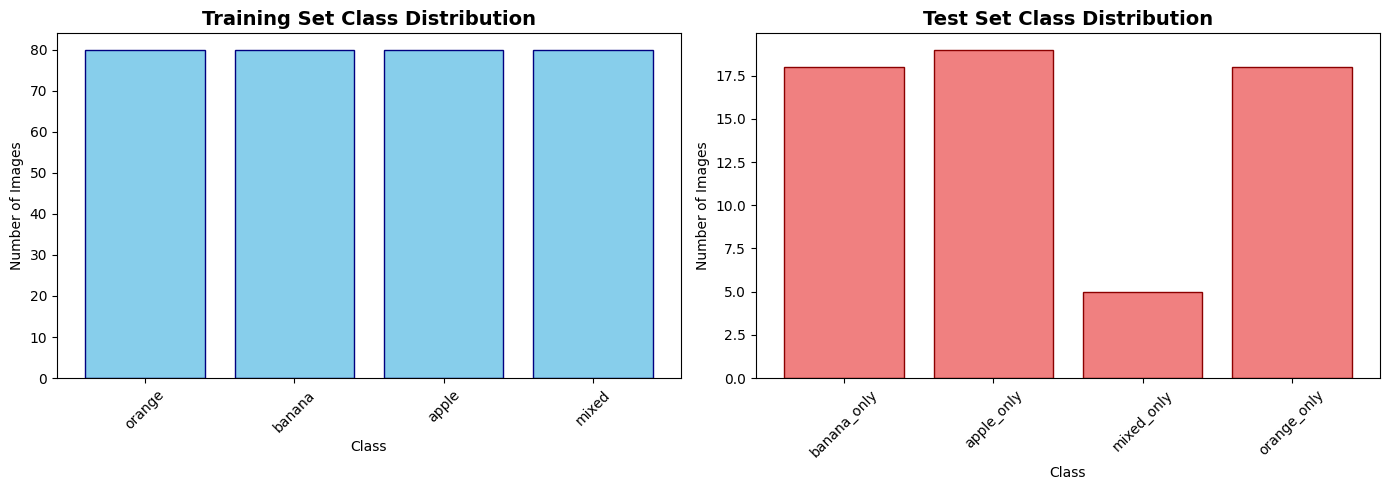

In [21]:
def plot_class_distribution(train_counts, test_counts):
    # Visualize class distribution
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Training set distribution
    ax1.bar(train_counts.keys(), train_counts.values(), color='skyblue', edgecolor='navy')
    ax1.set_title('Training Set Class Distribution', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Class')
    ax1.set_ylabel('Number of Images')
    ax1.tick_params(axis='x', rotation=45)

    # Test set distribution
    ax2.bar(test_counts.keys(), test_counts.values(), color='lightcoral', edgecolor='darkred')
    ax2.set_title('Test Set Class Distribution', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Class')
    ax2.set_ylabel('Number of Images')
    ax2.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()


plot_class_distribution(train_counts, test_counts)

## 4. Data Preprocessing and Augmentation

In [22]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from pathlib import Path

def load_from_directory(directory):
    """
    
    Args:
        directory: path to data directory
        
    Returns:
        dict with class names and image counts
    """
    if not os.path.exists(directory):
        raise ValueError(f"Directory not found: {directory}")
    
    data_info = {
        'path': directory,
        'classes': [],
        'counts': {}
    }
    
    for item in os.listdir(directory):
        class_path = os.path.join(directory, item)
        if os.path.isdir(class_path):
            images = [f for f in os.listdir(class_path) 
                     if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]
            if images:
                data_info['classes'].append(item)
                data_info['counts'][item] = len(images)
    
    data_info['total'] = sum(data_info['counts'].values())
    data_info['num_classes'] = len(data_info['classes'])
    
    return data_info


def get_preprocessor(method='baseline', img_size=224, batch_size=32, train_dir=train_dir, test_dir=test_dir, val_split=0.2):
    """
    Get data generators with different preprocessing methods
    
    Args:
        method: 'baseline', 'light', 'heavy', 'moderate', 'minimal', 'color_boost', 'mixed'
        img_size: image dimension (default 224)
        batch_size: batch size for training (default 32)
        train_dir: training data directory
        test_dir: test data directory
        val_split: validation split ratio (default 0.2)
    
    Returns:
        train_gen, val_gen, test_gen
    """
    
    if method == 'baseline':
        train_datagen = ImageDataGenerator(rescale=1./255, validation_split=val_split)
        
    elif method == 'light':
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=15,
            horizontal_flip=True,
            validation_split=val_split
        )
        
    elif method == 'heavy':
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=30,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            vertical_flip=True,
            brightness_range=[0.8, 1.2],
            validation_split=val_split
        )
        
    elif method == 'moderate':
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            validation_split=val_split
        )
        
    elif method == 'minimal':
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=10,
            zoom_range=0.1,
            validation_split=val_split
        )

    elif method == 'heavy':
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=45,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest',
            validation_split=val_split
        )

    elif method == 'color_boost':
        train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.15,
        height_shift_range=0.15,
        zoom_range=0.15,
        horizontal_flip=True,
        brightness_range=[0.7, 1.3],   # vary lighting
        channel_shift_range=15.0,      # vary colors
        validation_split=val_split
    )
        
    elif method == 'mixed':
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=40,
            width_shift_range=0.25,
            height_shift_range=0.25,
            shear_range=0.25,
            zoom_range=0.35,
            horizontal_flip=True,
            vertical_flip=True,
            brightness_range=[0.5, 1.5],
            channel_shift_range=35.0,
            fill_mode='nearest',
            validation_split=val_split
        )

        
    else:
        raise ValueError(f"Unknown method: {method}. Choose from: baseline, light, heavy, moderate, minimal")
    
    test_datagen = ImageDataGenerator(rescale=1./255)
    
    train_gen = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='categorical',
        subset='training'
    )
    
    val_gen = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation'
    )
    
    test_gen = test_datagen.flow_from_directory(
        test_dir,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )
    
    return train_gen, val_gen, test_gen


def list_methods():
    methods = {
        'baseline': 'No augmentation, only rescaling',
        'light': 'Rotation (15°) + Horizontal flip',
        'heavy': 'Full augmentation (rotation, shift, zoom, shear, brightness, flips)',
        'moderate': 'Balanced augmentation (rotation, shift, zoom, flip)',
        'minimal': 'Minimal augmentation (slight rotation, zoom)',
        'color_boost': 'Moderate geometry + brightness [0.7–1.3] + channel shift',
        'mixed': 'intensive mix: strong geometry + brightness [0.5–1.5] + channel shift'

    }
    print("Available preprocessing methods:")
    for key, desc in methods.items():
        print(f"  - {key:12s}: {desc}")
    return methods


In [ ]:
train_generator,validation_generator,test_generator = get_preprocessor(method='baseline', img_size=224, batch_size=32, train_dir=train_dir, test_dir=test_dir, val_split=0.2)


print(f"\nTraining samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {test_generator.samples}")
print(f"\nClass indices: {train_generator.class_indices}")


## 5. Build Basic CNN Model

In [ ]:
def create_cnn_model():

    model = models.Sequential()

    #Convolution blocks
    model.add(layers.Conv2D(32, kernel_size = (3,3), 
                    padding='same',
                    input_shape=(IMG_SIZE, IMG_SIZE, 3),
                    activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=2)) 

    model.add(layers.Conv2D(64, kernel_size = (3,3), 
                    padding='same',
                    activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=2)) 

    model.add(layers.Conv2D(128, kernel_size = (3,3), 
                    padding='same',
                    activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=2))

    #Classification layers
    model.add(layers.Flatten())

    model.add(layers.Dense(64,activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(32,activation='relu'))

    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(NUM_CLASSES,activation='softmax'))


    model.summary()

    
    
    return model

# Create model
model = create_cnn_model()

# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model Architecture:")
model.summary()

## 6. Setup Training Callbacks

In [ ]:
# Setup callbacks
callbacks = [
    # Early stopping: stop training if validation loss doesn't improve for 10 epochs
    EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True,
        verbose=1
    ),
    
    # Model checkpoint: save best model
    ModelCheckpoint(
        'best_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    
    # Learning rate reduction: reduce LR if validation loss stops improving
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

print("Callbacks configured")

## 7. Train Model

In [ ]:
import time
start_time = time.time()
# Train model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=callbacks,
    verbose=1
)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"\nTraining completed in {elapsed_time:.2f} seconds!")

## 8. Visualize Training History

In [ ]:
# Plot training and validation accuracy and loss
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy curves
ax1.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
ax1.set_title('Model Accuracy', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='lower right')
ax1.grid(True, alpha=0.3)

# Loss curves
ax2.plot(history.history['loss'], label='Training Loss', linewidth=2)
ax2.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
ax2.set_title('Model Loss', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print best results
best_epoch = np.argmax(history.history['val_accuracy'])
print(f"\nBest Epoch: {best_epoch + 1}")
print(f"Best Validation Accuracy: {history.history['val_accuracy'][best_epoch]:.4f}")
print(f"Corresponding Training Accuracy: {history.history['accuracy'][best_epoch]:.4f}")

## 9. Evaluate Model on Test Set

In [ ]:
# Evaluate on test set
# First check if test generator has samples
if test_generator.samples == 0:
    print("Warning: Test set is empty! Creating test generator again...")
    # Recreate test generator without shuffle to ensure proper loading
    test_generator = test_generator.flow_from_directory(
        test_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )
    print(f"Test samples loaded: {test_generator.samples}")

if test_generator.samples > 0:
    test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
    
    print(f"\n{'='*50}")
    print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"{'='*50}")
    
    # Check if target accuracy is reached
    if test_accuracy >= 0.92:
        print(f"Congratulations! Target accuracy of 92% achieved!")
    else:
        print(f"Current accuracy {test_accuracy*100:.2f}% below 92% target, further optimization needed")
else:
    print("\n" + "="*50)
    print("ERROR: No test images found!")
    print(f"Please check the test directory: {test_dir}")
    print("Expected structure: test_dir/class_name/images.jpg")
    print("="*50)

## 10. Generate Confusion Matrix

In [ ]:
# Get predictions
from sklearn.metrics import confusion_matrix, classification_report

# Check if test set has samples before predicting
if test_generator.samples == 0:
    print("Cannot generate predictions: Test set is empty!")
    print("Please add test images to the test directory first.")
else:
    # Reset test generator
    test_generator.reset()
    
    # Predict
    y_pred = model.predict(test_generator, verbose=1)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    # True labels
    y_true = test_generator.classes
    
    # Class labels
    class_labels = list(test_generator.class_indices.keys())
    
    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_labels, 
                yticklabels=class_labels,
                cbar_kws={'label': 'Count'})
    plt.title('Confusion Matrix', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Predicted Class', fontsize=12)
    plt.ylabel('True Class', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    # Print classification report
    print("\nClassification Report:")
    print("="*60)
    print(classification_report(y_true, y_pred_classes, target_names=class_labels, digits=4))

## 11. Visualize Prediction Examples

In [ ]:
# Display prediction samples
from tensorflow.keras.preprocessing import image

def show_predictions(num_images=9):
    """Display prediction results"""
    if test_generator.samples == 0:
        print("Cannot show predictions: Test set is empty!")
        return
    
    # Reset test generator
    test_generator.reset()
    
    # Get a batch of images
    images, labels = next(test_generator)
    predictions = model.predict(images[:num_images])
    
    # Plot
    num_to_show = min(num_images, len(images))
    rows = int(np.ceil(num_to_show / 3))
    fig, axes = plt.subplots(rows, 3, figsize=(15, 5 * rows))
    if rows == 1:
        axes = axes.reshape(1, -1)
    axes = axes.ravel()
    
    for i in range(num_to_show):
        axes[i].imshow(images[i])
        
        true_label = class_labels[np.argmax(labels[i])]
        pred_label = class_labels[np.argmax(predictions[i])]
        pred_prob = np.max(predictions[i]) * 100
        
        color = 'green' if true_label == pred_label else 'red'
        axes[i].set_title(f'True: {true_label}\nPredicted: {pred_label} ({pred_prob:.1f}%)',
                         color=color, fontsize=10, fontweight='bold')
        axes[i].axis('off')
    
    # Hide extra subplots
    for i in range(num_to_show, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

show_predictions(9)

## 12. Save Model

In [ ]:
# Save model in native Keras format (recommended)
model.save('fruit_classifier_cnn.keras')
print("Model saved as 'fruit_classifier_cnn.keras' (Native Keras format)")

# Also save in HDF5 format for compatibility
model.save('fruit_classifier_cnn.h5')
print("Model saved as 'fruit_classifier_cnn.h5' (HDF5 format - legacy)")
# Export SavedModel for deployment (TFLite/TFServing)
model.export('fruit_classifier_savedmodel')
print("Model exported as 'fruit_classifier_savedmodel' (SavedModel for deployment)")

print("\n" + "=" * 60)
print("Model Saving Summary:")
print("  • fruit_classifier_cnn.keras     - Native Keras (recommended)")
print("  • fruit_classifier_cnn.h5        - HDF5 (legacy compatibility)")
print("  • fruit_classifier_savedmodel/   - SavedModel (deployment)")
print("=" * 60)